In [131]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [132]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [133]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\原数据\K_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:0]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.001
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [134]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [135]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [136]:
batch_size=256

In [137]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [138]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [139]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [140]:
prediction_result_cv = []
prediction_result_ind = []

In [141]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze')

In [142]:
out = os.getcwd() + '\\'

In [143]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0  

8/8 - 0s - loss: 0.4814 - accuracy: 0.7726 - val_loss: 0.5661 - val_accuracy: 0.6667

Epoch 00030: val_loss did not improve from 0.53728
Epoch 31/300
8/8 - 0s - loss: 0.4746 - accuracy: 0.7667 - val_loss: 0.5457 - val_accuracy: 0.7378

Epoch 00031: val_loss did not improve from 0.53728
Epoch 32/300
8/8 - 0s - loss: 0.4707 - accuracy: 0.7672 - val_loss: 0.5720 - val_accuracy: 0.7200

Epoch 00032: val_loss did not improve from 0.53728
Epoch 33/300
8/8 - 0s - loss: 0.4656 - accuracy: 0.7657 - val_loss: 0.5988 - val_accuracy: 0.7156

Epoch 00033: val_loss did not improve from 0.53728
Epoch 34/300
8/8 - 0s - loss: 0.4627 - accuracy: 0.7795 - val_loss: 0.5593 - val_accuracy: 0.6800

Epoch 00034: val_loss did not improve from 0.53728
Epoch 35/300
8/8 - 0s - loss: 0.4595 - accuracy: 0.7766 - val_loss: 0.5404 - val_accuracy: 0.7333

Epoch 00035: val_loss did not improve from 0.53728
Epoch 36/300
8/8 - 0s - loss: 0.4630 - accuracy: 0.7721 - val_loss: 0.5507 - val_accuracy: 0.7244

Epoch 00036: v

8/8 - 1s - loss: 0.6607 - accuracy: 0.6090 - val_loss: 0.6338 - val_accuracy: 0.6622

Epoch 00001: val_loss improved from inf to 0.63380, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_1.h5
Epoch 2/300
8/8 - 0s - loss: 0.6107 - accuracy: 0.6698 - val_loss: 0.6017 - val_accuracy: 0.6844

Epoch 00002: val_loss improved from 0.63380 to 0.60175, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_1.h5
Epoch 3/300
8/8 - 0s - loss: 0.5998 - accuracy: 0.6673 - val_loss: 0.5919 - val_accuracy: 0.7111

Epoch 00003: val_loss improved from 0.60175 to 0.59190, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_1.h5
Epoch 4/300
8/8 - 0s - loss: 0.5850 - accuracy: 0.6817 - val_loss: 0.5851 - val_accuracy: 0.7156

Epoch 00004: val_loss improved from 0.59190 to 0.58513, saving model to D:\Pyc


Epoch 00043: val_loss improved from 0.52814 to 0.52364, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_1.h5
Epoch 44/300
8/8 - 0s - loss: 0.4486 - accuracy: 0.7879 - val_loss: 0.5301 - val_accuracy: 0.7244

Epoch 00044: val_loss did not improve from 0.52364
Epoch 45/300
8/8 - 0s - loss: 0.4076 - accuracy: 0.8201 - val_loss: 0.5259 - val_accuracy: 0.7289

Epoch 00045: val_loss did not improve from 0.52364
Epoch 46/300
8/8 - 0s - loss: 0.4230 - accuracy: 0.7949 - val_loss: 0.5755 - val_accuracy: 0.6800

Epoch 00046: val_loss did not improve from 0.52364
Epoch 47/300
8/8 - 0s - loss: 0.4338 - accuracy: 0.7978 - val_loss: 0.5235 - val_accuracy: 0.7200

Epoch 00047: val_loss improved from 0.52364 to 0.52351, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_1.h5
Epoch 48/300
8/8 - 0s - loss: 0.4257 - accuracy: 0.8008 - val_loss: 0.5286 - val_accur

8/8 - 0s - loss: 0.3430 - accuracy: 0.8468 - val_loss: 0.5250 - val_accuracy: 0.6889

Epoch 00094: val_loss did not improve from 0.51500
Epoch 95/300
8/8 - 0s - loss: 0.2686 - accuracy: 0.8898 - val_loss: 0.5372 - val_accuracy: 0.6978

Epoch 00095: val_loss did not improve from 0.51500
Epoch 96/300
8/8 - 0s - loss: 0.3031 - accuracy: 0.8784 - val_loss: 0.5413 - val_accuracy: 0.6933

Epoch 00096: val_loss did not improve from 0.51500
Epoch 97/300
8/8 - 0s - loss: 0.2857 - accuracy: 0.8754 - val_loss: 0.5304 - val_accuracy: 0.7022

Epoch 00097: val_loss did not improve from 0.51500
Epoch 98/300
8/8 - 0s - loss: 0.2505 - accuracy: 0.8972 - val_loss: 0.6454 - val_accuracy: 0.7067

Epoch 00098: val_loss did not improve from 0.51500
Epoch 99/300
8/8 - 0s - loss: 0.3191 - accuracy: 0.8665 - val_loss: 0.5461 - val_accuracy: 0.6933

Epoch 00099: val_loss did not improve from 0.51500
Epoch 100/300
8/8 - 0s - loss: 0.2874 - accuracy: 0.8739 - val_loss: 0.5676 - val_accuracy: 0.6889

Epoch 00100: 

8/8 - 0s - loss: 0.5637 - accuracy: 0.7014 - val_loss: 0.5799 - val_accuracy: 0.6978

Epoch 00007: val_loss did not improve from 0.57912
Epoch 8/300
8/8 - 0s - loss: 0.5537 - accuracy: 0.7158 - val_loss: 0.5664 - val_accuracy: 0.7244

Epoch 00008: val_loss improved from 0.57912 to 0.56638, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_2.h5
Epoch 9/300
8/8 - 0s - loss: 0.5343 - accuracy: 0.7227 - val_loss: 0.5973 - val_accuracy: 0.6533

Epoch 00009: val_loss did not improve from 0.56638
Epoch 10/300
8/8 - 0s - loss: 0.5411 - accuracy: 0.7093 - val_loss: 0.5568 - val_accuracy: 0.7333

Epoch 00010: val_loss improved from 0.56638 to 0.55679, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_2.h5
Epoch 11/300
8/8 - 0s - loss: 0.5452 - accuracy: 0.7128 - val_loss: 0.5639 - val_accuracy: 0.7378

Epoch 00011: val_loss did not improve from 0.55679
Epo

8/8 - 0s - loss: 0.4052 - accuracy: 0.8097 - val_loss: 0.5549 - val_accuracy: 0.7067

Epoch 00055: val_loss did not improve from 0.51220
Epoch 56/300
8/8 - 0s - loss: 0.3889 - accuracy: 0.8220 - val_loss: 0.6116 - val_accuracy: 0.6578

Epoch 00056: val_loss did not improve from 0.51220
Epoch 57/300
8/8 - 0s - loss: 0.3797 - accuracy: 0.8265 - val_loss: 0.5423 - val_accuracy: 0.7200

Epoch 00057: val_loss did not improve from 0.51220
Epoch 58/300
8/8 - 0s - loss: 0.3633 - accuracy: 0.8290 - val_loss: 0.5583 - val_accuracy: 0.7289

Epoch 00058: val_loss did not improve from 0.51220
Epoch 59/300
8/8 - 0s - loss: 0.3920 - accuracy: 0.8186 - val_loss: 0.5365 - val_accuracy: 0.7156

Epoch 00059: val_loss did not improve from 0.51220
Epoch 60/300
8/8 - 0s - loss: 0.3725 - accuracy: 0.8285 - val_loss: 0.5288 - val_accuracy: 0.7333

Epoch 00060: val_loss did not improve from 0.51220
Epoch 61/300
8/8 - 0s - loss: 0.3902 - accuracy: 0.8151 - val_loss: 0.5555 - val_accuracy: 0.7333

Epoch 00061: v

8/8 - 1s - loss: 0.6604 - accuracy: 0.5991 - val_loss: 0.6122 - val_accuracy: 0.6978

Epoch 00001: val_loss improved from inf to 0.61219, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_3.h5
Epoch 2/300
8/8 - 0s - loss: 0.6080 - accuracy: 0.6728 - val_loss: 0.5899 - val_accuracy: 0.6889

Epoch 00002: val_loss improved from 0.61219 to 0.58987, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_3.h5
Epoch 3/300
8/8 - 0s - loss: 0.5922 - accuracy: 0.6703 - val_loss: 0.5656 - val_accuracy: 0.7156

Epoch 00003: val_loss improved from 0.58987 to 0.56557, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_3.h5
Epoch 4/300
8/8 - 0s - loss: 0.5641 - accuracy: 0.7064 - val_loss: 0.5785 - val_accuracy: 0.7067

Epoch 00004: val_loss did not improve from 0.56557
Epoch 5/300
8/8 - 0s - loss

8/8 - 0s - loss: 0.4477 - accuracy: 0.7840 - val_loss: 0.5103 - val_accuracy: 0.7467

Epoch 00041: val_loss did not improve from 0.49364
Epoch 42/300
8/8 - 0s - loss: 0.4368 - accuracy: 0.7944 - val_loss: 0.5447 - val_accuracy: 0.7200

Epoch 00042: val_loss did not improve from 0.49364
Epoch 43/300
8/8 - 0s - loss: 0.4342 - accuracy: 0.7939 - val_loss: 0.4922 - val_accuracy: 0.7511

Epoch 00043: val_loss improved from 0.49364 to 0.49221, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_3.h5
Epoch 44/300
8/8 - 0s - loss: 0.4580 - accuracy: 0.7766 - val_loss: 0.4945 - val_accuracy: 0.7422

Epoch 00044: val_loss did not improve from 0.49221
Epoch 45/300
8/8 - 0s - loss: 0.4377 - accuracy: 0.7870 - val_loss: 0.4945 - val_accuracy: 0.7467

Epoch 00045: val_loss did not improve from 0.49221
Epoch 46/300
8/8 - 0s - loss: 0.4421 - accuracy: 0.8018 - val_loss: 0.4986 - val_accuracy: 0.7511

Epoch 00046: val_loss did not imp


Epoch 00090: val_loss did not improve from 0.48416
Epoch 91/300
8/8 - 0s - loss: 0.3349 - accuracy: 0.8478 - val_loss: 0.5467 - val_accuracy: 0.7200

Epoch 00091: val_loss did not improve from 0.48416
Epoch 92/300
8/8 - 0s - loss: 0.2787 - accuracy: 0.8888 - val_loss: 0.5128 - val_accuracy: 0.7422

Epoch 00092: val_loss did not improve from 0.48416
Epoch 93/300
8/8 - 0s - loss: 0.3045 - accuracy: 0.8720 - val_loss: 0.5031 - val_accuracy: 0.7422

Epoch 00093: val_loss did not improve from 0.48416
Epoch 94/300
8/8 - 0s - loss: 0.3117 - accuracy: 0.8552 - val_loss: 0.5217 - val_accuracy: 0.7556

Epoch 00094: val_loss did not improve from 0.48416
Epoch 95/300
8/8 - 0s - loss: 0.2914 - accuracy: 0.8730 - val_loss: 0.5043 - val_accuracy: 0.7600

Epoch 00095: val_loss did not improve from 0.48416
Epoch 96/300
8/8 - 0s - loss: 0.3010 - accuracy: 0.8705 - val_loss: 0.4968 - val_accuracy: 0.7422

Epoch 00096: val_loss did not improve from 0.48416
Epoch 97/300
8/8 - 0s - loss: 0.2823 - accuracy:

8/8 - 1s - loss: 0.6454 - accuracy: 0.6139 - val_loss: 0.6529 - val_accuracy: 0.5511

Epoch 00001: val_loss improved from inf to 0.65289, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_4.h5
Epoch 2/300
8/8 - 0s - loss: 0.6162 - accuracy: 0.6589 - val_loss: 0.6278 - val_accuracy: 0.6178

Epoch 00002: val_loss improved from 0.65289 to 0.62778, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_4.h5
Epoch 3/300
8/8 - 0s - loss: 0.5918 - accuracy: 0.6802 - val_loss: 0.5938 - val_accuracy: 0.6800

Epoch 00003: val_loss improved from 0.62778 to 0.59381, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_4.h5
Epoch 4/300
8/8 - 0s - loss: 0.5887 - accuracy: 0.6782 - val_loss: 0.5936 - val_accuracy: 0.6889

Epoch 00004: val_loss improved from 0.59381 to 0.59358, saving model to D:\Pyc


Epoch 00043: val_loss did not improve from 0.53842
Epoch 44/300
8/8 - 0s - loss: 0.4304 - accuracy: 0.7954 - val_loss: 0.5498 - val_accuracy: 0.7022

Epoch 00044: val_loss did not improve from 0.53842
Epoch 45/300
8/8 - 0s - loss: 0.4368 - accuracy: 0.7894 - val_loss: 0.5382 - val_accuracy: 0.7200

Epoch 00045: val_loss improved from 0.53842 to 0.53815, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_4.h5
Epoch 46/300
8/8 - 0s - loss: 0.4581 - accuracy: 0.7800 - val_loss: 0.5455 - val_accuracy: 0.6844

Epoch 00046: val_loss did not improve from 0.53815
Epoch 47/300
8/8 - 0s - loss: 0.4326 - accuracy: 0.7998 - val_loss: 0.5452 - val_accuracy: 0.7111

Epoch 00047: val_loss did not improve from 0.53815
Epoch 48/300
8/8 - 0s - loss: 0.4071 - accuracy: 0.8166 - val_loss: 0.5509 - val_accuracy: 0.6978

Epoch 00048: val_loss did not improve from 0.53815
Epoch 49/300
8/8 - 0s - loss: 0.4254 - accuracy: 0.7998 - val_loss:

8/8 - 0s - loss: 0.3093 - accuracy: 0.8675 - val_loss: 0.5809 - val_accuracy: 0.7244

Epoch 00093: val_loss did not improve from 0.52358
Epoch 94/300
8/8 - 0s - loss: 0.3055 - accuracy: 0.8651 - val_loss: 0.5553 - val_accuracy: 0.6844

Epoch 00094: val_loss did not improve from 0.52358
Epoch 95/300
8/8 - 0s - loss: 0.3035 - accuracy: 0.8720 - val_loss: 0.5400 - val_accuracy: 0.6978

Epoch 00095: val_loss did not improve from 0.52358
Epoch 96/300
8/8 - 0s - loss: 0.2765 - accuracy: 0.8819 - val_loss: 0.5580 - val_accuracy: 0.7111

Epoch 00096: val_loss did not improve from 0.52358
Epoch 97/300
8/8 - 0s - loss: 0.2781 - accuracy: 0.8814 - val_loss: 0.5546 - val_accuracy: 0.6978

Epoch 00097: val_loss did not improve from 0.52358
Epoch 98/300
8/8 - 0s - loss: 0.3025 - accuracy: 0.8680 - val_loss: 0.5340 - val_accuracy: 0.7156

Epoch 00098: val_loss did not improve from 0.52358
Epoch 99/300
8/8 - 0s - loss: 0.2981 - accuracy: 0.8665 - val_loss: 0.5392 - val_accuracy: 0.7200

Epoch 00099: v

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_55 (Functional)        (None, 5, 128)            199680    
_________________________________________________________________
dense_110 (Dense)            (None, 5, 64)             8256      
_________________________________________________________________
dropout_55 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_55  (None, 64)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6561 - accuracy: 0.6125 - val_loss: 0.6358 - val_accuracy: 0.5911

Epoch 00001: va

8/8 - 0s - loss: 0.4640 - accuracy: 0.7751 - val_loss: 0.5089 - val_accuracy: 0.7378

Epoch 00035: val_loss did not improve from 0.50477
Epoch 36/300
8/8 - 0s - loss: 0.4732 - accuracy: 0.7667 - val_loss: 0.5050 - val_accuracy: 0.8000

Epoch 00036: val_loss did not improve from 0.50477
Epoch 37/300
8/8 - 0s - loss: 0.4512 - accuracy: 0.7840 - val_loss: 0.5307 - val_accuracy: 0.7378

Epoch 00037: val_loss did not improve from 0.50477
Epoch 38/300
8/8 - 0s - loss: 0.4517 - accuracy: 0.7850 - val_loss: 0.4959 - val_accuracy: 0.7822

Epoch 00038: val_loss improved from 0.50477 to 0.49588, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_5.h5
Epoch 39/300
8/8 - 0s - loss: 0.4360 - accuracy: 0.7810 - val_loss: 0.4996 - val_accuracy: 0.7644

Epoch 00039: val_loss did not improve from 0.49588
Epoch 40/300
8/8 - 0s - loss: 0.4418 - accuracy: 0.7830 - val_loss: 0.4938 - val_accuracy: 0.7867

Epoch 00040: val_loss improved fr


Epoch 00083: val_loss improved from 0.48267 to 0.48261, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_5.h5
Epoch 84/300
8/8 - 0s - loss: 0.2999 - accuracy: 0.8695 - val_loss: 0.4908 - val_accuracy: 0.7644

Epoch 00084: val_loss did not improve from 0.48261
Epoch 85/300
8/8 - 0s - loss: 0.2926 - accuracy: 0.8744 - val_loss: 0.4821 - val_accuracy: 0.7600

Epoch 00085: val_loss improved from 0.48261 to 0.48209, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_5.h5
Epoch 86/300
8/8 - 0s - loss: 0.3309 - accuracy: 0.8581 - val_loss: 0.4762 - val_accuracy: 0.7733

Epoch 00086: val_loss improved from 0.48209 to 0.47615, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_5.h5
Epoch 87/300
8/8 - 0s - loss: 0.2955 - accuracy: 0.8799 - val_loss: 0.4979 - val_accuracy: 0.7511

Epoch 


Epoch 00134: val_loss did not improve from 0.46884
Epoch 135/300
8/8 - 0s - loss: 0.2044 - accuracy: 0.9145 - val_loss: 0.5220 - val_accuracy: 0.7333

Epoch 00135: val_loss did not improve from 0.46884
Epoch 136/300
8/8 - 0s - loss: 0.1905 - accuracy: 0.9244 - val_loss: 0.5551 - val_accuracy: 0.7333

Epoch 00136: val_loss did not improve from 0.46884
Epoch 137/300
8/8 - 0s - loss: 0.2271 - accuracy: 0.9031 - val_loss: 0.5137 - val_accuracy: 0.7378

Epoch 00137: val_loss did not improve from 0.46884
Epoch 138/300
8/8 - 0s - loss: 0.1919 - accuracy: 0.9219 - val_loss: 0.5231 - val_accuracy: 0.7333

Epoch 00138: val_loss did not improve from 0.46884
Epoch 139/300
8/8 - 0s - loss: 0.2041 - accuracy: 0.9150 - val_loss: 0.5250 - val_accuracy: 0.7378

Epoch 00139: val_loss did not improve from 0.46884
Epoch 140/300
8/8 - 0s - loss: 0.2172 - accuracy: 0.9115 - val_loss: 0.5056 - val_accuracy: 0.7333

Epoch 00140: val_loss did not improve from 0.46884
Epoch 141/300
8/8 - 0s - loss: 0.1849 - ac


Epoch 00005: val_loss improved from 0.57443 to 0.57297, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_6.h5
Epoch 6/300
8/8 - 0s - loss: 0.5520 - accuracy: 0.7064 - val_loss: 0.5711 - val_accuracy: 0.7200

Epoch 00006: val_loss improved from 0.57297 to 0.57111, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_6.h5
Epoch 7/300
8/8 - 0s - loss: 0.5547 - accuracy: 0.7034 - val_loss: 0.5731 - val_accuracy: 0.7200

Epoch 00007: val_loss did not improve from 0.57111
Epoch 8/300
8/8 - 0s - loss: 0.5488 - accuracy: 0.7143 - val_loss: 0.5704 - val_accuracy: 0.7156

Epoch 00008: val_loss improved from 0.57111 to 0.57042, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_6.h5
Epoch 9/300
8/8 - 0s - loss: 0.5486 - accuracy: 0.7138 - val_loss: 0.5492 - val_accuracy: 0.7378

Epoch 0000


Epoch 00047: val_loss improved from 0.49950 to 0.49269, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_6.h5
Epoch 48/300
8/8 - 0s - loss: 0.4408 - accuracy: 0.7904 - val_loss: 0.4965 - val_accuracy: 0.7600

Epoch 00048: val_loss did not improve from 0.49269
Epoch 49/300
8/8 - 0s - loss: 0.4164 - accuracy: 0.8097 - val_loss: 0.5186 - val_accuracy: 0.7378

Epoch 00049: val_loss did not improve from 0.49269
Epoch 50/300
8/8 - 0s - loss: 0.4113 - accuracy: 0.8151 - val_loss: 0.5142 - val_accuracy: 0.7200

Epoch 00050: val_loss did not improve from 0.49269
Epoch 51/300
8/8 - 0s - loss: 0.4247 - accuracy: 0.7914 - val_loss: 0.4913 - val_accuracy: 0.7689

Epoch 00051: val_loss improved from 0.49269 to 0.49128, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_6.h5
Epoch 52/300
8/8 - 0s - loss: 0.3952 - accuracy: 0.8206 - val_loss: 0.5033 - val_accur


Epoch 00096: val_loss did not improve from 0.46947
Epoch 97/300
8/8 - 0s - loss: 0.2940 - accuracy: 0.8680 - val_loss: 0.4890 - val_accuracy: 0.7333

Epoch 00097: val_loss did not improve from 0.46947
Epoch 98/300
8/8 - 0s - loss: 0.2921 - accuracy: 0.8789 - val_loss: 0.5637 - val_accuracy: 0.6889

Epoch 00098: val_loss did not improve from 0.46947
Epoch 99/300
8/8 - 0s - loss: 0.2999 - accuracy: 0.8730 - val_loss: 0.4951 - val_accuracy: 0.7333

Epoch 00099: val_loss did not improve from 0.46947
Epoch 100/300
8/8 - 0s - loss: 0.2736 - accuracy: 0.8848 - val_loss: 0.4914 - val_accuracy: 0.7333

Epoch 00100: val_loss did not improve from 0.46947
Epoch 101/300
8/8 - 0s - loss: 0.2907 - accuracy: 0.8735 - val_loss: 0.5035 - val_accuracy: 0.7422

Epoch 00101: val_loss did not improve from 0.46947
Epoch 102/300
8/8 - 0s - loss: 0.3060 - accuracy: 0.8690 - val_loss: 0.4862 - val_accuracy: 0.7333

Epoch 00102: val_loss did not improve from 0.46947
Epoch 103/300
8/8 - 0s - loss: 0.2548 - accur

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_57 (Functional)        (None, 5, 128)            199680    
_________________________________________________________________
dense_114 (Dense)            (None, 5, 64)             8256      
_________________________________________________________________
dropout_57 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_57  (None, 64)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6562 - accuracy: 0.6149 - val_loss: 0.6210 - val_accuracy: 0.6933

Epoch 00001: va


Epoch 00038: val_loss did not improve from 0.52132
Epoch 39/300
8/8 - 0s - loss: 0.4517 - accuracy: 0.7845 - val_loss: 0.5341 - val_accuracy: 0.7111

Epoch 00039: val_loss did not improve from 0.52132
Epoch 40/300
8/8 - 0s - loss: 0.4487 - accuracy: 0.7884 - val_loss: 0.5271 - val_accuracy: 0.7244

Epoch 00040: val_loss did not improve from 0.52132
Epoch 41/300
8/8 - 0s - loss: 0.4413 - accuracy: 0.7845 - val_loss: 0.5202 - val_accuracy: 0.7733

Epoch 00041: val_loss improved from 0.52132 to 0.52023, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_7.h5
Epoch 42/300
8/8 - 0s - loss: 0.4326 - accuracy: 0.7968 - val_loss: 0.5216 - val_accuracy: 0.7511

Epoch 00042: val_loss did not improve from 0.52023
Epoch 43/300
8/8 - 0s - loss: 0.4206 - accuracy: 0.8062 - val_loss: 0.5181 - val_accuracy: 0.7511

Epoch 00043: val_loss improved from 0.52023 to 0.51810, saving model to D:\PycharmProjects\pythonProject\Papernew_data

8/8 - 0s - loss: 0.3004 - accuracy: 0.8759 - val_loss: 0.5479 - val_accuracy: 0.7289

Epoch 00090: val_loss did not improve from 0.51024
Epoch 91/300
8/8 - 0s - loss: 0.2932 - accuracy: 0.8749 - val_loss: 0.5734 - val_accuracy: 0.7022

Epoch 00091: val_loss did not improve from 0.51024
Epoch 92/300
8/8 - 0s - loss: 0.3089 - accuracy: 0.8611 - val_loss: 0.5428 - val_accuracy: 0.7289

Epoch 00092: val_loss did not improve from 0.51024
Epoch 93/300
8/8 - 0s - loss: 0.3104 - accuracy: 0.8547 - val_loss: 0.6356 - val_accuracy: 0.6622

Epoch 00093: val_loss did not improve from 0.51024
Epoch 94/300
8/8 - 0s - loss: 0.2746 - accuracy: 0.8883 - val_loss: 0.5277 - val_accuracy: 0.7511

Epoch 00094: val_loss did not improve from 0.51024
Epoch 95/300
8/8 - 0s - loss: 0.3278 - accuracy: 0.8621 - val_loss: 0.5266 - val_accuracy: 0.7689

Epoch 00095: val_loss did not improve from 0.51024
Epoch 96/300
8/8 - 0s - loss: 0.2675 - accuracy: 0.8868 - val_loss: 0.5307 - val_accuracy: 0.7511

Epoch 00096: v

8/8 - 0s - loss: 0.5416 - accuracy: 0.7213 - val_loss: 0.5488 - val_accuracy: 0.7188

Epoch 00012: val_loss improved from 0.54994 to 0.54876, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_8.h5
Epoch 13/300
8/8 - 0s - loss: 0.5406 - accuracy: 0.7337 - val_loss: 0.5541 - val_accuracy: 0.7054

Epoch 00013: val_loss did not improve from 0.54876
Epoch 14/300
8/8 - 0s - loss: 0.5079 - accuracy: 0.7490 - val_loss: 0.5436 - val_accuracy: 0.7054

Epoch 00014: val_loss improved from 0.54876 to 0.54363, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_8.h5
Epoch 15/300
8/8 - 0s - loss: 0.5271 - accuracy: 0.7292 - val_loss: 0.5393 - val_accuracy: 0.7188

Epoch 00015: val_loss improved from 0.54363 to 0.53927, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_8.h5
Epoch 16/300
8/8 - 0


Epoch 00056: val_loss did not improve from 0.50499
Epoch 57/300
8/8 - 0s - loss: 0.3961 - accuracy: 0.8182 - val_loss: 0.5122 - val_accuracy: 0.7321

Epoch 00057: val_loss did not improve from 0.50499
Epoch 58/300
8/8 - 0s - loss: 0.4179 - accuracy: 0.7984 - val_loss: 0.5021 - val_accuracy: 0.7188

Epoch 00058: val_loss improved from 0.50499 to 0.50214, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_8.h5
Epoch 59/300
8/8 - 0s - loss: 0.3751 - accuracy: 0.8335 - val_loss: 0.5073 - val_accuracy: 0.7143

Epoch 00059: val_loss did not improve from 0.50214
Epoch 60/300
8/8 - 0s - loss: 0.3730 - accuracy: 0.8261 - val_loss: 0.5046 - val_accuracy: 0.7098

Epoch 00060: val_loss did not improve from 0.50214
Epoch 61/300
8/8 - 0s - loss: 0.4163 - accuracy: 0.8162 - val_loss: 0.5009 - val_accuracy: 0.7232

Epoch 00061: val_loss improved from 0.50214 to 0.50086, saving model to D:\PycharmProjects\pythonProject\Papernew_data

8/8 - 0s - loss: 0.2254 - accuracy: 0.9106 - val_loss: 0.5152 - val_accuracy: 0.7366

Epoch 00107: val_loss did not improve from 0.49545
Epoch 108/300
8/8 - 0s - loss: 0.3329 - accuracy: 0.8592 - val_loss: 0.5591 - val_accuracy: 0.7277

Epoch 00108: val_loss did not improve from 0.49545
Epoch 109/300
8/8 - 0s - loss: 0.2654 - accuracy: 0.8893 - val_loss: 0.5399 - val_accuracy: 0.7188

Epoch 00109: val_loss did not improve from 0.49545
Epoch 110/300
8/8 - 0s - loss: 0.2427 - accuracy: 0.9017 - val_loss: 0.5179 - val_accuracy: 0.7411

Epoch 00110: val_loss did not improve from 0.49545
Epoch 111/300
8/8 - 0s - loss: 0.2575 - accuracy: 0.8962 - val_loss: 0.5673 - val_accuracy: 0.7188

Epoch 00111: val_loss did not improve from 0.49545
Epoch 112/300
8/8 - 0s - loss: 0.2302 - accuracy: 0.9071 - val_loss: 0.5470 - val_accuracy: 0.7321

Epoch 00112: val_loss did not improve from 0.49545
Epoch 113/300
8/8 - 0s - loss: 0.2953 - accuracy: 0.8671 - val_loss: 0.5258 - val_accuracy: 0.7188

Epoch 00

8/8 - 0s - loss: 0.5264 - accuracy: 0.7391 - val_loss: 0.5798 - val_accuracy: 0.6652

Epoch 00013: val_loss did not improve from 0.55914
Epoch 14/300
8/8 - 0s - loss: 0.5274 - accuracy: 0.7372 - val_loss: 0.5427 - val_accuracy: 0.7455

Epoch 00014: val_loss improved from 0.55914 to 0.54269, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\_9.h5
Epoch 15/300
8/8 - 0s - loss: 0.5581 - accuracy: 0.7105 - val_loss: 0.5541 - val_accuracy: 0.7500

Epoch 00015: val_loss did not improve from 0.54269
Epoch 16/300
8/8 - 0s - loss: 0.5124 - accuracy: 0.7520 - val_loss: 0.5576 - val_accuracy: 0.7188

Epoch 00016: val_loss did not improve from 0.54269
Epoch 17/300
8/8 - 0s - loss: 0.5183 - accuracy: 0.7268 - val_loss: 0.5646 - val_accuracy: 0.6964

Epoch 00017: val_loss did not improve from 0.54269
Epoch 18/300
8/8 - 0s - loss: 0.5303 - accuracy: 0.7268 - val_loss: 0.5678 - val_accuracy: 0.6920

Epoch 00018: val_loss did not imp


Epoch 00063: val_loss did not improve from 0.51851
Epoch 64/300
8/8 - 0s - loss: 0.3764 - accuracy: 0.8375 - val_loss: 0.5456 - val_accuracy: 0.7545

Epoch 00064: val_loss did not improve from 0.51851
Epoch 65/300
8/8 - 0s - loss: 0.3662 - accuracy: 0.8355 - val_loss: 0.5376 - val_accuracy: 0.7188

Epoch 00065: val_loss did not improve from 0.51851
Epoch 66/300
8/8 - 0s - loss: 0.3579 - accuracy: 0.8305 - val_loss: 0.6164 - val_accuracy: 0.6875

Epoch 00066: val_loss did not improve from 0.51851
Epoch 67/300
8/8 - 0s - loss: 0.4041 - accuracy: 0.8256 - val_loss: 0.5444 - val_accuracy: 0.7321

Epoch 00067: val_loss did not improve from 0.51851
Epoch 68/300
8/8 - 0s - loss: 0.3679 - accuracy: 0.8330 - val_loss: 0.5607 - val_accuracy: 0.7098

Epoch 00068: val_loss did not improve from 0.51851
Epoch 69/300
8/8 - 0s - loss: 0.3350 - accuracy: 0.8498 - val_loss: 0.5373 - val_accuracy: 0.7455

Epoch 00069: val_loss did not improve from 0.51851
Epoch 70/300
8/8 - 0s - loss: 0.3864 - accuracy:

In [144]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [145]:
roc_auc_list_val

[0.7944058154235145,
 0.8283641581632654,
 0.807759165613148,
 0.7922724399494311,
 0.8241150442477876,
 0.7951959544879899,
 0.8545353982300885,
 0.8437895069532237,
 0.8260113780025284,
 0.8214285714285714]

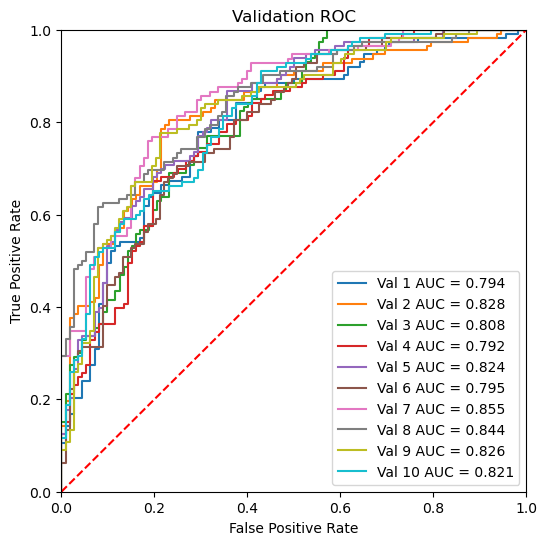

In [146]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

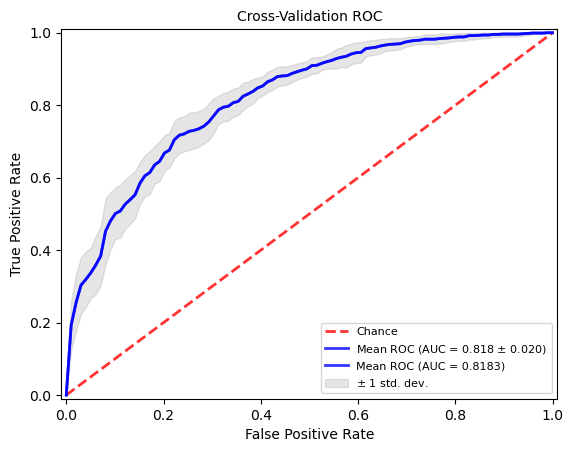

In [147]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [148]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [149]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [150]:
my_calculate_metrics_list_val

[{'SN': 0.6017699115044248,
  'SP': 0.8214285714285714,
  'ACC': 0.7111111111111111,
  'MCC': 0.4336014397759082,
  'Recall': 0.6017699115044248,
  'Precision': 0.7727272727272727,
  'F1-score': 0.6766169154228856,
  'Cutoff': 0.5},
 {'SN': 0.8482142857142857,
  'SP': 0.6339285714285714,
  'ACC': 0.7410714285714286,
  'MCC': 0.49360888628581323,
  'Recall': 0.8482142857142857,
  'Precision': 0.6985294117647058,
  'F1-score': 0.7661290322580645,
  'Cutoff': 0.5},
 {'SN': 0.8495575221238938,
  'SP': 0.5803571428571429,
  'ACC': 0.7155555555555555,
  'MCC': 0.4466378743113777,
  'Recall': 0.8495575221238938,
  'Precision': 0.6713286713286714,
  'F1-score': 0.75,
  'Cutoff': 0.5},
 {'SN': 0.8407079646017699,
  'SP': 0.5803571428571429,
  'ACC': 0.7111111111111111,
  'MCC': 0.4363291909502756,
  'Recall': 0.8407079646017699,
  'Precision': 0.6690140845070423,
  'F1-score': 0.7450980392156863,
  'Cutoff': 0.5},
 {'SN': 0.584070796460177,
  'SP': 0.8660714285714286,
  'ACC': 0.724444444444444

In [151]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.601770,0.821429,0.711111,0.433601,0.601770,0.772727,0.676617,0.5
1,0.848214,0.633929,0.741071,0.493609,0.848214,0.698529,0.766129,0.5
2,0.849558,0.580357,0.715556,0.446638,0.849558,0.671329,0.750000,0.5
3,0.840708,0.580357,0.711111,0.436329,0.840708,0.669014,0.745098,0.5
4,0.584071,0.866071,0.724444,0.468894,0.584071,0.814815,0.680412,0.5
5,0.803571,0.628319,0.715556,0.438524,0.803571,0.681818,0.737705,0.5
6,0.821429,0.707965,0.764444,0.532686,0.821429,0.736000,0.776371,0.5
7,0.714286,0.761062,0.737778,0.475912,0.714286,0.747664,0.730594,0.5
8,0.875000,0.539823,0.706667,0.439982,0.875000,0.653333,0.748092,0.5
9,0.794643,0.651786,0.723214,0.451055,0.794643,0.695312,0.741667,0.5


In [152]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.601770,0.821429,0.711111,0.433601,0.601770,0.772727,0.676617,0.5
1,0.848214,0.633929,0.741071,0.493609,0.848214,0.698529,0.766129,0.5
2,0.849558,0.580357,0.715556,0.446638,0.849558,0.671329,0.750000,0.5
3,0.840708,0.580357,0.711111,0.436329,0.840708,0.669014,0.745098,0.5
4,0.584071,0.866071,0.724444,0.468894,0.584071,0.814815,0.680412,0.5
5,0.803571,0.628319,0.715556,0.438524,0.803571,0.681818,0.737705,0.5
6,0.821429,0.707965,0.764444,0.532686,0.821429,0.736000,0.776371,0.5
7,0.714286,0.761062,0.737778,0.475912,0.714286,0.747664,0.730594,0.5
8,0.875000,0.539823,0.706667,0.439982,0.875000,0.653333,0.748092,0.5
9,0.794643,0.651786,0.723214,0.451055,0.794643,0.695312,0.741667,0.5


In [153]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [154]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [155]:
roc_auc_list_indep

[0.8237404336734695,
 0.8353794642857143,
 0.821109693877551,
 0.8164062500000001,
 0.8166454081632654,
 0.8274872448979592,
 0.8055644132653061,
 0.8055644132653061,
 0.8176020408163266,
 0.8129783163265306]

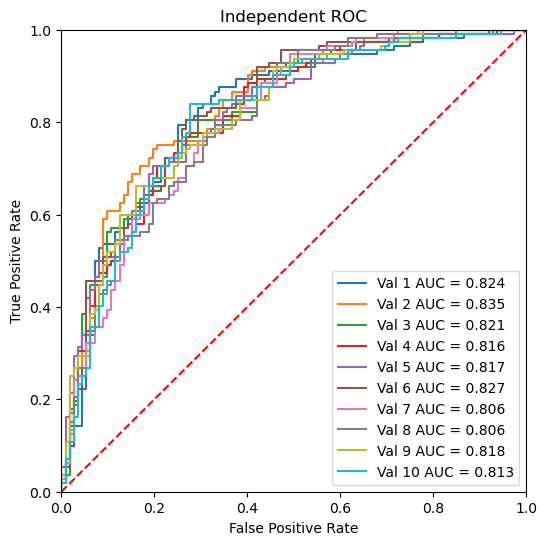

In [156]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

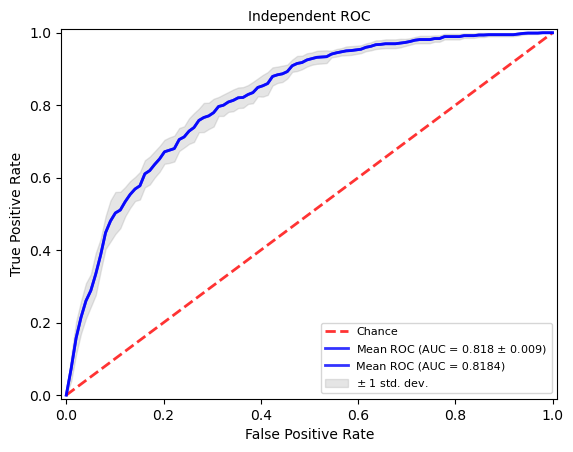

In [157]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [158]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [159]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [160]:
my_calculate_metrics_list_indep

[{'SN': 0.625,
  'SP': 0.8214285714285714,
  'ACC': 0.7232142857142857,
  'MCC': 0.4552986372567942,
  'Recall': 0.625,
  'Precision': 0.7777777777777778,
  'F1-score': 0.693069306930693,
  'Cutoff': 0.5},
 {'SN': 0.8214285714285714,
  'SP': 0.6607142857142857,
  'ACC': 0.7410714285714286,
  'MCC': 0.4884927886700595,
  'Recall': 0.8214285714285714,
  'Precision': 0.7076923076923077,
  'F1-score': 0.7603305785123967,
  'Cutoff': 0.5},
 {'SN': 0.8214285714285714,
  'SP': 0.6160714285714286,
  'ACC': 0.71875,
  'MCC': 0.44702745039491154,
  'Recall': 0.8214285714285714,
  'Precision': 0.6814814814814815,
  'F1-score': 0.7449392712550608,
  'Cutoff': 0.5},
 {'SN': 0.8482142857142857,
  'SP': 0.6071428571428571,
  'ACC': 0.7276785714285714,
  'MCC': 0.46919493272208973,
  'Recall': 0.8482142857142857,
  'Precision': 0.6834532374100719,
  'F1-score': 0.7569721115537849,
  'Cutoff': 0.5},
 {'SN': 0.5178571428571429,
  'SP': 0.875,
  'ACC': 0.6964285714285714,
  'MCC': 0.4205955120960299,
  '

In [161]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.625000,0.821429,0.723214,0.455299,0.625000,0.777778,0.693069,0.5
1,0.821429,0.660714,0.741071,0.488493,0.821429,0.707692,0.760331,0.5
2,0.821429,0.616071,0.718750,0.447027,0.821429,0.681481,0.744939,0.5
3,0.848214,0.607143,0.727679,0.469195,0.848214,0.683453,0.756972,0.5
4,0.517857,0.875000,0.696429,0.420596,0.517857,0.805556,0.630435,0.5
5,0.821429,0.687500,0.754464,0.513555,0.821429,0.724409,0.769874,0.5
6,0.776786,0.669643,0.723214,0.449013,0.776786,0.701613,0.737288,0.5
7,0.633929,0.794643,0.714286,0.434216,0.633929,0.755319,0.689320,0.5
8,0.848214,0.580357,0.714286,0.444826,0.848214,0.669014,0.748031,0.5
9,0.821429,0.723214,0.772321,0.547289,0.821429,0.747967,0.782979,0.5


In [162]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.625000,0.821429,0.723214,0.455299,0.625000,0.777778,0.693069,0.5
1,0.821429,0.660714,0.741071,0.488493,0.821429,0.707692,0.760331,0.5
2,0.821429,0.616071,0.718750,0.447027,0.821429,0.681481,0.744939,0.5
3,0.848214,0.607143,0.727679,0.469195,0.848214,0.683453,0.756972,0.5
4,0.517857,0.875000,0.696429,0.420596,0.517857,0.805556,0.630435,0.5
5,0.821429,0.687500,0.754464,0.513555,0.821429,0.724409,0.769874,0.5
6,0.776786,0.669643,0.723214,0.449013,0.776786,0.701613,0.737288,0.5
7,0.633929,0.794643,0.714286,0.434216,0.633929,0.755319,0.689320,0.5
8,0.848214,0.580357,0.714286,0.444826,0.848214,0.669014,0.748031,0.5
9,0.821429,0.723214,0.772321,0.547289,0.821429,0.747967,0.782979,0.5


In [163]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\unfreeze\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [164]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

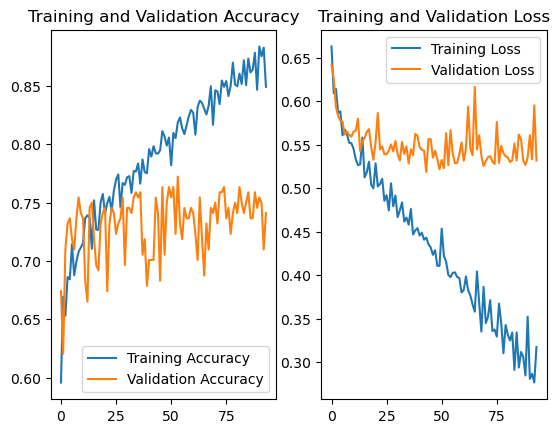

In [165]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()